# Boosting With Neural Networks

## Markdown Section

### Representation

Let $H$ be the class of base, un-boosted hypotheses. Then, $E$ is defined as the ensemble of $H$ weak learners of size $T$.

$$E(H, T) = {x \to sign(Σ(w_t * h_t(x))) : w ∈ R^T, ∀t, h_t ∈ H}$$

### Loss

We are using L2 loss for both the one-layer neural network and the boosted ensemble of hypotheses.
For each single-layer neural network, loss is defined as:
$$L_S(h_{\bf t}) = \sum\limits_{i=1}^m(y_{i}-h_{\bf t}({\bf x}_{i}))^{2}$$

where *y*<sub>i</sub> is the target value of *i*<sup>th</sup>
sample and $h_{\bf t}({\bf x})$ is the predicted value of that
sample given the learned model weights.

For the ensemble, loss is then defined as:
$$L_S(E(H, T)) = \sum\limits_{i=1}^m(y_{i}-E(H, T)({\bf x}_{i}))^{2}$$

### Optimzer

Input:
Training set $S = \{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_m, y_m)\}$
Weak learner $Wl$
Number of rounds $T$

Initialize:
$D^{(1)} = \left(\frac{1}{m}, \ldots, \frac{1}{m}\right)$

For $t = 1, \ldots, T$:

$h_t = WL(D^{(t)}, S)$

$\epsilon_t = \sum_{i=1}^m D_i^{(t)} \mathbb{1}[y_i \neq h_t(\mathbf{x}_i)]$

$w_t = \frac{1}{2} \log \left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$

$D_i^{(t+1)} = \frac{D_i^{(t)} \exp(-w_t y_i h_t(\mathbf{x}_i))}{\sum_{j=1}^m D_j^{(t)} \exp(-w_t y_j h_t(\mathbf{x}_j))} \quad \forall i = 1, \ldots, m$

Output:
The hypothesis: $h_S(\mathbf{x}) = \text{sign}\left(\sum_{t=1}^T w_t h_t(\mathbf{x})\right)$

### Representation

Let $H$ be the class of base, un-boosted hypotheses. Then, $E$ is defined as the ensemble of $H$ weak learners of size $T$.

$$E(H, T) = {x \to sign(Σ(w_t * h_t(x))) : w ∈ R^T, ∀t, h_t ∈ H}$$

### Loss

$ε_t = L_D(t)(h_t) = \sum_{i=0}^mD_i^t * \ell(h_t(x_i))$, where $D(t) ∈ R^m$

In our model, the loss function $\ell$ can either be 0-1 loss or l2 loss, depending on the type of dataset we are dealing with.


### Check Version

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)


print()
requirements = {'matplotlib': "3.9.1", 'numpy': "2.0.1",'sklearn': "1.5.1",
                'pandas': "2.2.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] matplotlib version 3.9.1 is installed.
[ OK ] numpy version 2.0.1 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.


## Model Section

### Weak Learner: One Layer Neural Network

In [2]:
# from sklearn.tree import DecisionTreeRegressor

# class DecisionTreeStump:
#     def __init__(self):
#         self.tree = DecisionTreeRegressor(max_depth=1)  # depth 1 for stump

#     def train(self, X, Y, data_weights):
#         self.tree.fit(X, Y, sample_weight=data_weights)

#     def predict(self, X):
#         return self.tree.predict(X)



import numpy as np
import random

def l2_loss_weight(predictions,Y,weights):
    '''
        Computes L2 loss (sum squared loss) between true values, Y, and predictions.
        that are weighted
        :param Y: A 1D Numpy array with real values (float64)
        :param predictions: A 1D Numpy array of the same size of Y
        :param weights: A 1D Numpy array of the same size of Y,
        :return: Weighted L2 loss using predictions for Y.
    '''

    return np.sum(weights * (predictions - Y)**2)

class OneLayerNN:
    '''
        One layer neural network trained with Stocastic Gradient Descent (SGD)
    '''
    def __init__(self):
        '''
        @attrs:
            weights: The weights of the neural network model.
            batch_size: The number of examples in each batch
            learning_rate: The learning rate to use for SGD
            epochs: The number of times to pass through the dataset
            v: The resulting predictions computed during the forward pass
        '''
        # initialize self.weights in train()
        self.weights = None
        self.learning_rate = 0.001
        self.epochs = 25
        self.batch_size = 1

        # initialize self.v in forward_pass()
        self.v = None
    
    def train(self, X, Y, data_weights):
        '''
        Trains the OneLayerNN model using SGD.
        :param X: 2D Numpy array where each row contains an example
        :param Y: 1D Numpy array containing the corresponding values for each example
        :param print_loss: If True, print the loss after each epoch.
        :return: None
        '''
        # TODO: initialize weights
        num_examples, num_features = X.shape
        self.weights = np.random.uniform(0, 1, (1, num_features))
        self.data_weights = data_weights
        # TODO: Train network for certain number of epochs
        for epoch in range(self.epochs):
            # TODO: Shuffle the examples (X) and labels (Y)
            indices = np.random.permutation(num_examples)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]
        # TODO: We need to iterate over each data point for each epoch
        # iterate through the examples in batch size increments
            for i in range(num_examples):

                x_i = X_shuffled[i].reshape(1, num_features)
                y_i = Y_shuffled[i].reshape(1, 1)            

                # TODO: Perform the forward and backward pass on the current batch
                self.forward_pass(x_i)
                self.backward_pass(x_i, y_i)

            # Print the loss after every epoch
            # if print_loss:
            #     print('Epoch: {} | Loss: {}'.format(epoch, self.loss(X, Y)))

    def forward_pass(self, X):
        '''
        Computes the predictions for a single layer given examples X and
        stores them in self.v
        :param X: 2D Numpy array where each row contains an example.
        :return: None
        '''
        # TODO:
        self.v = np.dot(self.weights, X.T)

    def backward_pass(self, X, Y):
        '''
        Computes the weights gradient and updates self.weights
        :param X: 2D Numpy array where each row contains an example
        :param Y: 1D Numpy array containing the corresponding values for each example
        :return: None
        '''
        # TODO: Compute the gradients for the model's weights using backprop
        gradient = self.backprop(X, Y)
        # TODO: Update the weights using gradient descent
        self.gradient_descent(gradient)

    def backprop(self, X, Y):
        '''
        Returns the average weights gradient for the given batch
        :param X: 2D Numpy array where each row contains an example.
        :param Y: 1D Numpy array containing the corresponding values for each example
        :return: A 1D Numpy array representing the weights gradient
        '''
        # TODO: Compute the average weights gradient
        # Refer to the SGD algorithm in slide 12 in Lecture 17: Backpropagation
        loss = self.v - Y
        return np.dot(2*loss, X)

    def gradient_descent(self, grad_W):
        '''
        Updates the weights using the given gradient
        :param grad_W: A 1D Numpy array representing the weights gradient
        :return: None
        '''
        self.weights -= (self.learning_rate * grad_W)

    def loss(self, X, Y, data_weights):
        '''
        Returns the total squared error on some dataset (X, Y).
        :param X: 2D Numpy array where each row contains an example
        :param Y: 1D Numpy array containing the corresponding values for each example
        :return: A float which is the squared error of the model on the dataset
        '''
        # Perform the forward pass and compute the l2 loss
        self.forward_pass(X)
        return l2_loss_weight(self.v, Y, data_weights)

    def average_loss(self, X, Y, data_weights):
        '''
        Returns the mean squared error on some dataset (X, Y).
        MSE = Total squared error/# of examples
        :param X: 2D Numpy array where each row contains an example
        :param Y: 1D Numpy array containing the corresponding values for each example
        :return: A float which is the mean squared error of the model on the dataset
        '''
        return self.loss(X, Y, data_weights) / X.shape[0]
    def predict(self, X):
        '''
            Returns the predicted values for some dataset (X).
            :param X: 2D Numpy array where each row contains an example
            :return: 1D Numpy array containing the predicted values for each example
        '''
        self.forward_pass(X)
        return self.v
    
# class OneLayerNN:
#     '''
#         One layer neural network trained with Stocastic Gradient Descent (SGD)
#     '''
#     def __init__(self):
#         '''
#         @attrs:
#             weights: The weights of the neural network model.
#             batch_size: The number of examples in each batch
#             learning_rate: The learning rate to use for SGD
#             epochs: The number of times to pass through the dataset
#             v: The resulting predictions computed during the forward pass
#         '''
#         # initialize self.weights in train()
#         self.weights = None
#         self.learning_rate = 0.001
#         self.epochs = 25
#         self.batch_size = 1

#         # initialize self.v in forward_pass()
#         self.v = None

#     def train(self, X, Y, data_weights, print_loss=False):
#         '''
#         Trains the OneLayerNN model using SGD.
#         :param X: 2D Numpy array where each row contains an example
#         :param Y: 1D Numpy array containing the corresponding values for each example
#         :param print_loss: If True, print the loss after each epoch.
#         :return: None
#         '''
#         # Initialize weights
#         input_size = X.shape[1]
#         self.weights = np.random.uniform(0,1,(1, input_size))
#         #print("Weights Initial Shape: ", self.weights.shape)

#         # Train network for certain number of epochs
#         for epoch in range(self.epochs):

#             # Shuffle the examples (X) and labels (Y)
#             rand_index = np.arange(X.shape[0])
#             np.random.shuffle(rand_index)
#             X_s = X[rand_index]
#             Y_s = Y[rand_index]
#             data_weights_s = data_weights[rand_index]

#              # iterate through the examples in batch size increments
#             for i in range((int(np.ceil(X_s.shape[0] / self.batch_size)))):
#                 X_batch = X_s[i * self.batch_size : (i + 1) * self.batch_size]
#                 Y_batch = Y_s[i * self.batch_size : (i + 1) * self.batch_size]
#                 data_weights_batch = data_weights_s[i * self.batch_size: (i + 1) * self.batch_size]


#                 #Perform the forward and backward pass on the current batch
#                 self.forward_pass(X_batch)
#                 self.backward_pass(X_batch, Y_batch, data_weights_batch)

#             # Print the loss after every epoch
#             if print_loss:
#                 print('Epoch: {} | Loss: {}'.format(epoch, self.loss(X, Y, data_weights_batch)))

#     def forward_pass(self, X):
#         '''
#         Computes the predictions for a single layer given examples X and
#         stores them in self.v
#         :param X: 2D Numpy array where each row contains an example.
#         :return: None
#         '''

#         self.v = np.dot(self.weights, X.T) # + bias (no bias for now?)
#         #print("v shape: ", self.v.shape)



#     def backward_pass(self, X, Y, data_weights):
#         '''
#         Computes the weights gradient and updates self.weights
#         :param X: 2D Numpy array where each row contains an example
#         :param Y: 1D Numpy array containing the corresponding values for each example
#         :return: None
#         '''
#         # Compute the gradients for the model's weights using backprop
#         grads = self.backprop(X,Y, data_weights)

#         # Update the weights using gradient descent
#         self.gradient_descent(grads)



#     def backprop(self, X, Y, data_weights):
#         '''
#         Returns the average weights gradient for the given batch
#         :param X: 2D Numpy array where each row contains an example.
#         :param Y: 1D Numpy array containing the corresponding values for each example
#         :return: A 1D Numpy array representing the weights gradient
#         '''
#         # Compute the average weights gradient
#         # Refer to the SGD algorithm in slide 12 in Lecture 17: Backpropagation

#         # The gradient dL/dw = -2 * xi * predictons (sum(yi-h(xi)))
#         m = X.shape[0]
#         grad_W = (2/m) * np.dot(X.T, data_weights * (self.v - Y))

#         #print("Shape of grad_W: ", grad_W.T.shape)

#         return grad_W.T

#     def gradient_descent(self, grad_W):
#         '''
#         Updates the weights using the given gradient
#         :param grad_W: A 1D Numpy array representing the weights gradient
#         :return: None
#         '''
#         # Update the weights using the given gradient and the learning rate
#         # Refer to the SGD algorithm in slide 12 in Lecture 17: Backpropagation
#         self.weights = self.weights - (self.learning_rate * grad_W)
#         #print(self.weights)


#     def loss(self, X, Y, data_weights):
#         '''
#         Returns the total squared error on some dataset (X, Y).
#         :param X: 2D Numpy array where each row contains an example
#         :param Y: 1D Numpy array containing the corresponding values for each example
#         :return: A float which is the squared error of the model on the dataset
#         '''
#         # Perform the forward pass and compute the l2 loss
#         self.forward_pass(X)
#         return l2_loss_weight(self.v, Y, data_weights)

#     def average_loss(self, X, Y, data_weights):
#         '''
#         Returns the mean squared error on some dataset (X, Y).
#         MSE = Total squared error/# of examples
#         :param X: 2D Numpy array where each row contains an example
#         :param Y: 1D Numpy array containing the corresponding values for each example
#         :return: A float which is the mean squared error of the model on the dataset
#         '''
#         return self.loss(X, Y, data_weights) / X.shape[0]

#     def predict(self, X):
#         '''
#         Returns the predicted values for some dataset (X).
#         :param X: 2D Numpy array where each row contains an example
#         :return: 1D Numpy array containing the predicted values for each example
#         '''
#         self.forward_pass(X)
#         return self.v

### Boosting Model

In [11]:
class Boosted_NN:
  def __init__(self, n_estimators=50, learning_rate=0.01, random_state=1):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.random_state = random_state
    self.estimator_weights = np.zeros(self.n_estimators)
    self.data_weights = []

    # Initialize the estimators
    self.estimators = []
    for i in range(self.n_estimators):
      self.estimators.append(OneLayerNN())

  def train(self, X, y):
    '''
    Trains/Fits the Boosting Model using AdaBoost.
    :param X: 2D Numpy array where each row contains an example
    :param Y: 1D Numpy array containing the corresponding values for each example
    '''
    # Initialize the data and estimator weights
    num_inputs = X.shape[0]
    self.data_weights = np.ones(num_inputs) / num_inputs

    # For each round/weak learner
    for i in range(self.n_estimators):

      # Use the weak learner
      weak_learner = self.estimators[i]

      # Fit the weak learner
      weak_learner.train(X, y, self.data_weights)
      # print(self.data_weights)
      #print("Before Reshape", weak_learner.predict(X).shape)
      y_pred = weak_learner.predict(X).reshape(num_inputs)
      #print("y_pred", y_pred)

      e_t = np.sum(self.data_weights * ((y-y_pred) **2)) / np.sum(self.data_weights)
      e_t = np.clip(e_t, 1e-10, 0.49)
      #e_t = e_t / num_inputs
      #print("weighted error", e_t)
      
      w_t = 0.5 * np.log((1 - e_t) / e_t)
      #print("w_t", w_t)

      self.estimator_weights[i] = w_t
      
      self.data_weights *= np.exp(-w_t * (y-y_pred)**2)
      self.data_weights = np.clip(self.data_weights, a_min=1e-10, a_max=1e2)
      self.data_weights /= np.sum(self.data_weights)
      #print(f"Sum of data weights (should be 1): {np.sum(self.data_weights)}")  
    
    self.estimator_weights = self.estimator_weights / np.sum(self.estimator_weights)
    # print(self.estimator_weights)

  def loss(self, X, Y):
      # Get predictions from all learners, then weight them
      #print("Shape of Y", Y.shape)
      #print("one prediction", self.estimators[0].predict(X).shape)
      predictions = np.array([e.predict(X) for e in self.estimators])
      #print("prediction shape", predictions.shape)
      predictions = predictions.reshape(self.n_estimators, Y.shape[0])
      #print("prediction shape", predictions.shape)
      #print("Original Pred", predictions)
      #print("Estimator Weights", self.estimator_weights)
      weighted_predictions = np.dot(self.estimator_weights, predictions)
      #print("Weighted", weighted_predictions)
      #print(Y)
      # L2 loss
      loss = np.mean((Y - weighted_predictions) ** 2)
      return loss
  
  def average_loss(self, X, Y):
        '''
        Returns the mean squared error on some dataset (X, Y).
        MSE = Total squared error/# of examples
        :param X: 2D Numpy array where each row contains an example
        :param Y: 1D Numpy array containing the corresponding values for each example
        :return: A float which is the mean squared error of the model on the dataset
        '''
        return self.loss(X, Y) / X.shape[0]


## Accuracy on Data Sets

In [12]:
from sklearn.model_selection import train_test_split
import os 


def test_models(dataset, test_size=0.2):
    '''
        Tests OneLayerNN, Boost on a given dataset.
        :param dataset The path to the dataset
        :return None
    '''

    # Check if the file exists
    if not os.path.exists(dataset):
        print('The file {} does not exist'.format(dataset))
        exit()

    # Load in the dataset
    data = np.loadtxt(dataset, skiprows = 1)
    X, Y = data[:, 1:], data[:, 0]

    # Normalize the features
    X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
    Y = Y 

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    print('Running models on {} dataset'.format(dataset))

    # Add a bias
    X_train_b = np.append(X_train, np.ones((len(X_train), 1)), axis=1)
    X_test_b = np.append(X_test, np.ones((len(X_test), 1)), axis=1)

    #### 1-Layer NN ######
    print('----- 1-Layer NN -----')
    nnmodel = OneLayerNN()
    nnmodel.train(X_train_b, Y_train, np.ones(X_train_b.shape[0]))
    print('Average Training Loss:', nnmodel.average_loss(X_train_b, Y_train, np.ones(X_train_b.shape[0])))
    print('Average Testing Loss:', nnmodel.average_loss(X_test_b, Y_test, np.ones(X_test_b.shape[0])))

    #### Boosted Neural Networks ######
    print('----- Boosted Neural Network -----')
    model = Boosted_NN(n_estimators=10)

    model.train(X_train_b, Y_train)

    print(X_train_b.shape)
    
    # this line errors 
    # Y_train = Y_train.reshape(-1,1)
    # Y_test = Y_test.reshape(-1,1)

    print('Average Training Loss:', model.loss(X_train_b, Y_train))
    print('Average Testing Loss:', model.loss(X_test_b, Y_test))

    #### Boosted Neural Networks ######
    print('----- Boosted Neural Network -----')

test_models('wine.txt')

Running models on wine.txt dataset
----- 1-Layer NN -----
Average Training Loss: 0.5725795965188172
Average Testing Loss: 0.5473367188464641
----- Boosted Neural Network -----
(3918, 12)
Average Training Loss: 0.5696423191226819
Average Testing Loss: 0.5501367377118578
----- Boosted Neural Network -----


In [95]:
# Test 
print(34.35 / 50)

0.687


----- 1-Layer NN -----
----- Boosted Neural Networks -----
Testing Boosted_NN with n_estimators=10, learning_rate=0.01
Training Loss: 0.5632835269908611, Testing Loss: 0.5717347390116724
Testing Boosted_NN with n_estimators=10, learning_rate=0.1
Training Loss: 0.5649697076055583, Testing Loss: 0.5793609791104092
Testing Boosted_NN with n_estimators=10, learning_rate=0.5
Training Loss: 0.5653582255542173, Testing Loss: 0.5728751409284943
Testing Boosted_NN with n_estimators=50, learning_rate=0.01
Training Loss: 0.5629615947160226, Testing Loss: 0.5705893600330035
Testing Boosted_NN with n_estimators=50, learning_rate=0.1
Training Loss: 0.5629757779688149, Testing Loss: 0.5678472522782095
Testing Boosted_NN with n_estimators=50, learning_rate=0.5
Training Loss: 0.5630892522550763, Testing Loss: 0.5710917464705745
Testing Boosted_NN with n_estimators=100, learning_rate=0.01
Training Loss: 0.5628889708472067, Testing Loss: 0.5703818710279801
Testing Boosted_NN with n_estimators=100, learni

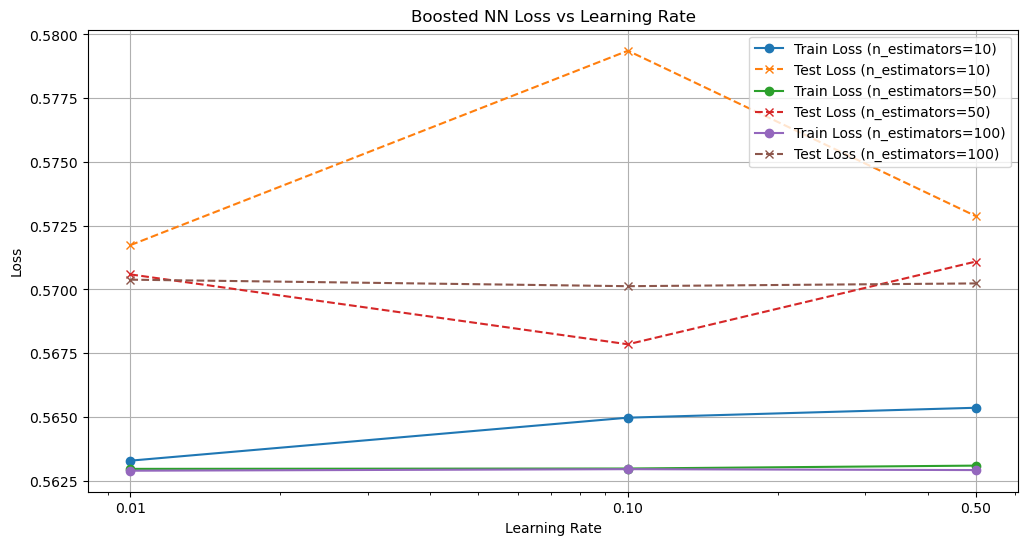

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def test_models_with_hyperparameters(dataset, test_size=0.2, n_estimators_list=[10, 50, 100], learning_rate_list=[0.01, 0.1, 0.5]):
    '''
        Tests OneLayerNN and Boosted_NN with varying hyperparameters.
        :param dataset: The path to the dataset
        :param test_size: Fraction of the dataset to be used for testing
        :param n_estimators_list: List of values for the number of estimators
        :param learning_rate_list: List of values for the learning rate
        :return: None
    '''

    # Check if the file exists
    if not os.path.exists(dataset):
        print(f'The file {dataset} does not exist')
        return

    # Load in the dataset
    data = np.loadtxt(dataset, skiprows=1)
    X, Y = data[:, 1:], data[:, 0]

    # Normalize the features
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Split dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

    # Add a bias term to the features
    X_train_b = np.append(X_train, np.ones((len(X_train), 1)), axis=1)
    X_test_b = np.append(X_test, np.ones((len(X_test), 1)), axis=1)

    # Results storage for plotting
    nn_train_losses = []
    nn_test_losses = []
    boosted_train_losses = {}
    boosted_test_losses = {}

    #### 1-Layer NN ######
    print('----- 1-Layer NN -----')
    nnmodel = OneLayerNN()
    nnmodel.train(X_train_b, Y_train, np.ones(X_train_b.shape[0]))
    nn_train_loss = nnmodel.average_loss(X_train_b, Y_train, np.ones(X_train_b.shape[0]))
    nn_test_loss = nnmodel.average_loss(X_test_b, Y_test, np.ones(X_test_b.shape[0]))
    nn_train_losses.append(nn_train_loss)
    nn_test_losses.append(nn_test_loss)
    # print('Average Training Loss (1-Layer NN):', nn_train_loss)
    # print('Average Testing Loss (1-Layer NN):', nn_test_loss)

    #### Boosted Neural Networks ######
    print('----- Boosted Neural Networks -----')
    for n_estimators in n_estimators_list:
        for learning_rate in learning_rate_list:
            print(f'Testing Boosted_NN with n_estimators={n_estimators}, learning_rate={learning_rate}')
            model = Boosted_NN(n_estimators=n_estimators, learning_rate=learning_rate)
            model.train(X_train_b, Y_train)
            train_loss = model.loss(X_train_b, Y_train)
            test_loss = model.loss(X_test_b, Y_test)
            print(f'Training Loss: {train_loss}, Testing Loss: {test_loss}')

            # Store results
            boosted_train_losses[(n_estimators, learning_rate)] = train_loss
            boosted_test_losses[(n_estimators, learning_rate)] = test_loss

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot for Boosted NN
    for n_estimators in n_estimators_list:
        train_losses = [boosted_train_losses[(n_estimators, lr)] for lr in learning_rate_list]
        test_losses = [boosted_test_losses[(n_estimators, lr)] for lr in learning_rate_list]
        
        ax.plot(learning_rate_list, train_losses, marker='o', label=f'Train Loss (n_estimators={n_estimators})')
        ax.plot(learning_rate_list, test_losses, marker='x', label=f'Test Loss (n_estimators={n_estimators})', linestyle='--')
    
    ax.set_title('Boosted NN Loss vs Learning Rate')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    ax.set_xscale('log')  # Keep the log scale for learning rates
    ax.set_xticks(learning_rate_list)  # Explicitly set the ticks
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Ensure proper formatting of tick labels
    ax.legend()
    ax.grid(True)
    plt.show()

test_models_with_hyperparameters('wine.txt')